In [49]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
!pip install lightgbm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

In [50]:
import os
os.getcwd()

'c:\\Users\\Terre\\Desktop\\2025_summer_intern\\8ff01516-c843-4dd5-bb72-1017d6f029c5'

#### 导入数据

In [51]:
# 'skus' table
skus = pd.read_csv('JD_sku_data.csv')
# 'users' table
users = pd.read_csv('JD_user_data.csv')
# 'clicks' table
clicks = pd.read_csv('JD_click_data.csv')
# 'orders' table
orders = pd.read_csv('JD_order_data.csv')
# 'delivery' table
delivery = pd.read_csv('JD_delivery_data.csv')
# 'inventory' table
inventory = pd.read_csv('JD_inventory_data.csv')
# 'network' table
network = pd.read_csv('JD_network_data.csv')

#### 查看数据样本

In [52]:
users.head(10)

,user_ID,user_level,first_order_month,plus,gender,age,marital_status,education,city_level,purchase_power
0,000089d6a6,1,2017-08,0,F,26-35,S,3,4,3
1,0000babd1f,1,2018-03,0,U,U,U,-1,-1,-1
2,0000bc018b,3,2016-06,0,F,>=56,M,3,2,3
3,0000d0e5ab,3,2014-06,0,M,26-35,M,3,2,2
4,0000dce472,3,2012-08,1,U,U,U,-1,-1,-1
5,0000f81d1b,1,2018-02,0,F,26-35,M,2,3,2
6,00012bb423,4,2008-11,1,F,26-35,M,4,1,2
7,00015ff032,3,2015-06,1,M,26-35,M,3,4,1
8,0001aa7059,4,2014-06,0,F,36-45,M,3,4,2
9,0001bbdc89,2,2017-12,0,F,16-25,S,3,2,2


#### 检查所有DateFrame所有变量的数据类型

In [53]:
dataframes = {
    'skus': skus,
    'users': users,
    'clicks': clicks,
    'orders': orders,
    'delivery': delivery,
    'inventory': inventory,
    'network': network
}
for name, df in dataframes.items():
    print(f"\nDataFrame: {name}")
    print("-" * 40)
    print(df.dtypes)


DataFrame: skus
----------------------------------------
sku_ID             object
type                int64
brand_ID           object
attribute1         object
attribute2         object
activate_date      object
deactivate_date    object
dtype: object

DataFrame: users
----------------------------------------
user_ID              object
user_level            int64
first_order_month    object
plus                  int64
gender               object
age                  object
marital_status       object
education             int64
city_level            int64
purchase_power        int64
dtype: object

DataFrame: clicks
----------------------------------------
sku_ID          object
user_ID         object
request_time    object
channel         object
dtype: object

DataFrame: orders
----------------------------------------
order_ID                       object
user_ID                        object
sku_ID                         object
order_date                     object
order_time     

#### 通过user_id合并users和orders，构建完整的用户-订单-商品表单

In [54]:
#通过user_id合并users和orders
orders_users = orders.merge(users, on="user_ID", how="left")
#再通过sku_id合并sku
#形成完整的用户-订单-商品表单
orders_users_sku = orders_users.merge(skus,on = 'sku_ID',how = "left")
# sample
orders_users_sku.head(100)

,order_ID,user_ID,sku_ID,order_date,order_time,quantity,type_x,promise,original_unit_price,final_unit_price,...,marital_status,education,city_level,purchase_power,type_y,brand_ID,attribute1,attribute2,activate_date,deactivate_date
0,d0cf5cc6db,0abe9ef2ce,581d5b54c1,2018-03-01,2018-03-01 17:14:25.0,1,2,-,89.0,79.0,...,M,3,2,2,2.0,198cec62a1,4.0,100.0,NaN,NaN
1,7444318d01,33a9e56257,067b673f2b,2018-03-01,2018-03-01 11:10:40.0,1,1,2,99.9,53.9,...,S,2,2,3,1.0,9b0d3a5fc6,3.0,60.0,NaN,NaN
2,f973b01694,4ea3cf408f,623d0a582a,2018-03-01,2018-03-01 09:13:26.0,1,1,2,78.0,58.5,...,S,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN
3,8c1cec8d4b,b87cb736cb,fc5289b139,2018-03-01,2018-03-01 21:29:50.0,1,1,2,61.0,35.0,...,M,3,2,2,NaN,NaN,NaN,NaN,NaN,NaN
4,d43a33c38a,4829223b6f,623d0a582a,2018-03-01,2018-03-01 19:13:37.0,1,1,1,78.0,53.0,...,M,2,2,4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,00a15f25f6,ff9d258307,26a569e595,2018-03-01,2018-03-01 23:00:22.0,1,1,3,108.0,86.0,...,M,4,2,2,NaN,NaN,NaN,NaN,NaN,NaN
96,45347a2ba0,cf41568d8d,7e4cb4952a,2018-03-01,2018-03-01 08:12:05.0,1,1,1,59.0,49.0,...,M,3,2,2,1.0,5ab8ea8556,2.0,80.0,NaN,NaN
97,15ba3b2c44,9b06f44f4d,c76a9ca5a8,2018-03-01,2018-03-01 20:59:29.0,1,1,4,109.0,44.0,...,S,3,2,2,1.0,b33770a360,3.0,80.0,NaN,NaN
98,ea6dd245e3,12f610851e,068f4481b3,2018-03-01,2018-03-01 23:14:42.0,1,1,1,298.0,198.0,...,M,4,2,3,1.0,99d41501ff,3.0,100.0,NaN,NaN


#### 基本统计量

In [55]:
#所有用户平均购买单价
avg_price = orders_users_sku['final_unit_price'].mean()
#最受欢迎品牌
top_brands = orders_users_sku['brand_ID'].value_counts().head(5)
# 平均教育水平
avg_edu = orders_users_sku['education'].mean()
# 是否婚配比例
marial = orders_users_sku['marital_status'].value_counts(normalize=True)
# 平均购买力
avg_purchase = orders_users_sku['purchase_power'].mean()
# 查看年龄频数
orders_users_sku['age'].value_counts().sort_index()

age
16-25    122272
26-35    220994
36-45     97716
46-55     22138
<=15         35
>=56      16895
U         69939
Name: count, dtype: int64

#### 初步探究：不同年龄段的用户是否在购买行为上有显著差异？可以制定什么样的推荐策略？

- 不同年龄段的平均下单金额

In [56]:
orders_users_sku.groupby('age')['final_unit_price'].mean().sort_index()

age
16-25    66.902430
26-35    74.511567
36-45    73.498619
46-55    73.545330
<=15     50.498571
>=56     68.135316
U        67.976205
Name: final_unit_price, dtype: float64

- 不同年龄段的订单数量（活跃程度）

In [57]:
orders_users_sku['age'].value_counts().sort_index()

age
16-25    122272
26-35    220994
36-45     97716
46-55     22138
<=15         35
>=56      16895
U         69939
Name: count, dtype: int64

- 年龄段 × 品牌偏好

In [58]:
orders_users_sku.groupby('age')['brand_ID'].agg(lambda x: x.value_counts().index[0])

age
16-25    9b0d3a5fc6
26-35    99d41501ff
36-45    99d41501ff
46-55    99d41501ff
<=15     5ab8ea8556
>=56     5ab8ea8556
U        5ab8ea8556
Name: brand_ID, dtype: object

- 显著性检验（ANOVA）检验不同年龄段下单金额是否显著不同：

In [59]:
from scipy.stats import f_oneway

groups = orders_users_sku.groupby('age')['final_unit_price'].apply(list).dropna()
f_oneway(*groups)


F_onewayResult(statistic=178.19591705178172, pvalue=1.6286139489957073e-227)

#### 检验结论
 - 根据单因子方差分析结果（F = 178.20, p < 0.001），可以认为不同年龄段用户的下单金额存在非常显著的统计差异。这说明年龄对消费金额有显著影响。

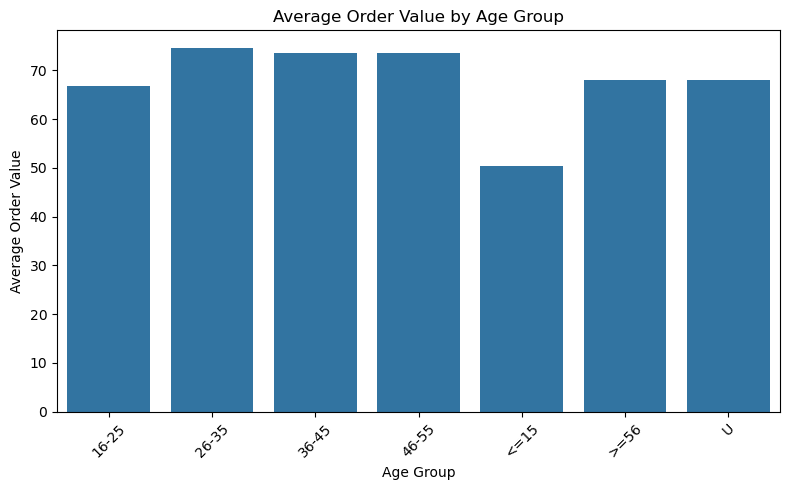

In [60]:
age_price_data = orders_users_sku[['age', 'final_unit_price']].dropna()

# 可视化
plt.figure(figsize=(8, 5))
sns.barplot(
    data=age_price_data,
    x='age',
    y='final_unit_price',
    estimator='mean',
    errorbar=None,
    order=sorted(age_price_data['age'].dropna().unique())
)
plt.title('Average Order Value by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Order Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

 #### 不同年龄段下单金额分析
  - 26–35、36–45、46–55平均下单金额最高（约 ¥74–75），是主要消费力群体
  - 16–25 和 >=56 平均下单金额较低（约 ¥66–68），潜力待挖掘
  - <=15	明显最低（约 ¥50），可能为异常值或极少量数据
  - U（未知年龄）	金额中等，说明数据质量待提升，可忽略

#### 结论
- 26–35、36–45、46–55平均下单金额最高，是主力消费群体，应针对该群体的购买习惯制定营销策略
- 但从柱状图可以看到总体的平均交易值并没有特别明显差异，尤其是主力消费群体差异较小，并且数据中不好含品牌详细类别（type），不好制定更细分的营销策略，选择转换分析角度，尝试更细分的分析角度

---

## 深入探究：非Plus用户转化策略

- Plus vs 非Plus用户订单金额分析

In [61]:
plus_group = orders_users_sku[orders_users_sku['plus'] == 1]['final_unit_price'].dropna()
non_plus_group = orders_users_sku[orders_users_sku['plus'] == 0]['final_unit_price'].dropna()
# 执行  t-test 
t_stat, p_value = ttest_ind(plus_group, non_plus_group, equal_var=False)

print(f"t 统计量 = {t_stat:.4f}")
print(f"p 值 = {p_value:.4e}")

print(len(plus_group))
print(len(non_plus_group))

t 统计量 = 33.7447
p 值 = 1.6379e-248
100675
449314


###  Plus vs 非 Plus 用户消费分析（独立样本 t 检验）

- **检验目的**：判断是否存在显著平均订单金额差异
- **方法**：Welch’s t-test（不假设方差齐性）
- **样本**
  - Plus 用户订单数量：100675
  - 非 Plus 用户订单数量：449314

####  检验结果：
- t 值：33.7447
- p 值：1.6379 × 10^-248（极显著）

####  小结：
- Plus 用户与非 Plus 用户的平均下单金额存在极显著差异。Plus 用户倾向于更高客单价商品，说明其具备更强消费力。

#### 策略：
- 重点维系 Plus 用户，更多推送单价更高的商品
---

#### Plus 用户 vs 非 Plus 用户订单金额基础分析

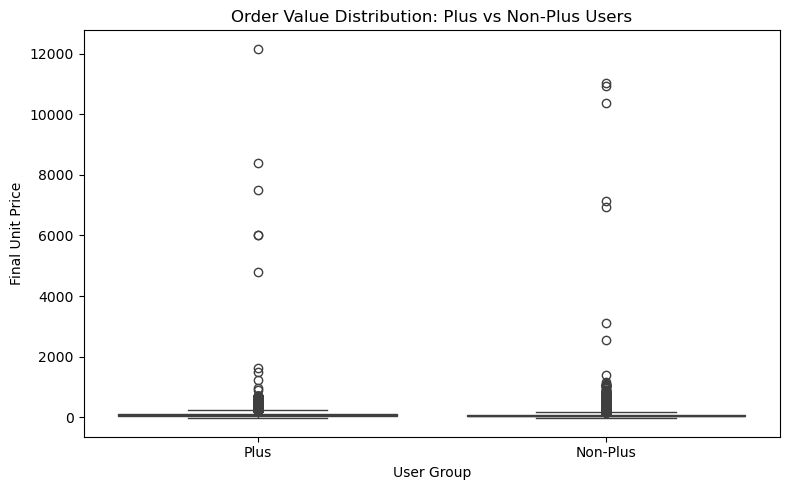

In [62]:
plus_group_labeled = plus_group.to_frame(name='final_unit_price')
plus_group_labeled['group'] = 'Plus'

non_plus_group_labeled = non_plus_group.to_frame(name='final_unit_price')
non_plus_group_labeled['group'] = 'Non-Plus'

combined_data = pd.concat([plus_group_labeled, non_plus_group_labeled])

# 可视化
plt.figure(figsize=(8, 5))
sns.boxplot(x='group', y='final_unit_price', data=combined_data)
plt.title('Order Value Distribution: Plus vs Non-Plus Users')
plt.xlabel('User Group')
plt.ylabel('Final Unit Price')
plt.tight_layout()
plt.show()

In [63]:
# 统计指标：均值、中位数、标准差、高价订单占比
plus_summary = {
    'mean': plus_group.mean(),
    'median': plus_group.median(),
    'std': plus_group.std(),
    'high_price_ratio (>=500)': (plus_group >= 500).mean()
}
non_plus_summary = {
    'mean': non_plus_group.mean(),
    'median': non_plus_group.median(),
    'std': non_plus_group.std(),
    'high_price_ratio (>=500)': (non_plus_group >= 500).mean()
}
summary_df = pd.DataFrame({'Plus': plus_summary, 'Non-Plus': non_plus_summary})
print(summary_df)

                               Plus   Non-Plus
mean                      80.351875  69.605481
median                    59.000000  58.000000
std                       95.353521  70.635212
high_price_ratio (>=500)   0.001361   0.000677


####  Plus 用户 vs 非 Plus 用户订单金额基础统计分析
---

####  关键指标对比：

 |指标 |                   Plus 用户 |    非 Plus 用户 |   分析   |      
 |-------------|-------------------|-------------|--------|                                       
 | 平均订单金额 (mean) |      80.35 |        69.61 |         Plus 用户平均消费更高，单笔订单金额多出约 10  |       
 | 订单金额中位数 (median) |  59.00    |     58.00    |   中位数相近，说明大多数用户的下单金额分布较为一致  |     
 | 标准差 (std)           |  95.35    |     70.64    |      Plus 用户价格波动更大，存在更多高价/低价订单    |    
 |高价订单占比（ratio）    | 0.1361%   |     0.0677%   |     Plus用户的高价订单占比约为非Plus用户的两倍|

 ---


####  分析结论：

- Plus 用户具有更强消费能力和更广价格接受区间
- 价格中位数接近，差异主要来自少数高价订单的拉升
- 高价订单（≥ 500）在 Plus 用户中出现更频繁，说明高价订单用户可能与Plus用户有潜在联系
- Plus 用户更值得引导高客单、高复购和长期留存
- 但从boxplot中也可看出非Plus用户也有一定数量的高价订单，可深入探究这类用户与Plus用户的联系

---


### 探究高价值用户与Plus 用户之间的联系

- 定义高价值用户

In [64]:

agg_df = orders_users_sku.groupby('user_ID').agg({
    'final_unit_price': 'sum',
}).rename(columns={
    'final_unit_price': 'total_spent',
})
# 设置判断标准（金额前 25%）
threshold_amt = agg_df['total_spent'].quantile(0.75)
agg_df['is_high_value'] = (
    (agg_df['total_spent'] >= threshold_amt)
).astype(int)
agg_df = agg_df.merge(users[['user_ID', 'plus']], on='user_ID', how='left')
agg_df.head(10)

,user_ID,total_spent,is_high_value,plus
0,000089d6a6,215.00,1,0
1,0000babd1f,39.00,0,0
2,0000bc018b,79.00,0,0
3,0000d0e5ab,228.00,1,0
4,0000dce472,111.50,1,1
5,0000f81d1b,150.00,1,0
6,00012bb423,52.90,0,1
7,00015ff032,3.00,0,1
8,0001aa7059,30.08,0,0
9,0001bbdc89,45.90,0,0


### 检验高价值用户与Plus用户的相关性

In [65]:
contingency_table = pd.crosstab(agg_df['plus'], agg_df['is_high_value'])
print(contingency_table)

# 卡方检验
chi2, p, dof, expected = chi2_contingency(contingency_table)
#result
print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p:.4e}")


is_high_value       0      1
plus                        
0              285480  89183
1               53423  26811
Chi-square statistic: 3213.6918
P-value: 0.0000e+00


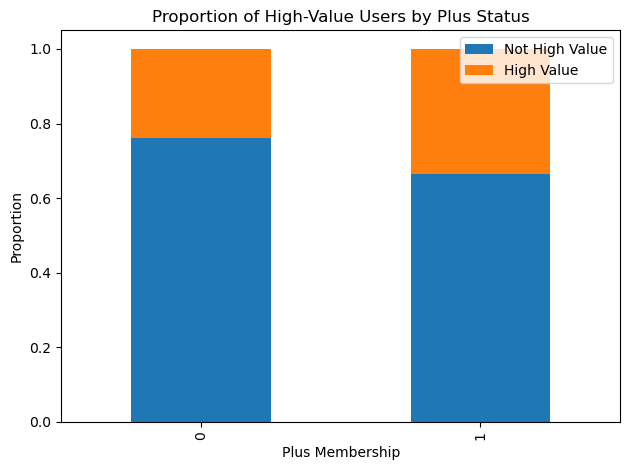

In [66]:

#可视化
normalized = contingency_table.div(contingency_table.sum(axis=1), axis=0)
normalized.plot(kind='bar', stacked=True)
plt.title("Proportion of High-Value Users by Plus Status")
plt.ylabel("Proportion")
plt.xlabel("Plus Membership")
plt.legend(["Not High Value", "High Value"], loc='upper right')
plt.tight_layout()
plt.show()


### Plus 会员身份 vs 高价值用户关联性分析

### 高价值用户定义：
- 消费金额前 25%

### 关键指标对比 :
|分类变量      |  非高价值用户      | 高价值用户   | 总计   | 高价值用户占比| 
|-------------|-------------------|-------------|--------|-------------|
|非Plus用户    | 285480           |    89183     | 374663|        23.8%|
|Plus用户 |    53424         |    26811     | 80234 |        33.4%|

### 统计方法： 卡方检验

####  卡方检验结果：
 - 卡方统计量:   3213.6918    
 - P_value     < 0.0001     
 - 在显著性水平 0.05 下，Plus 用户 与 高价值用户 的分布具有统计显著性差异，即两者存在强相关性。

#### 可视化解读：

- 非 Plus 用户中，高价值用户占比为 23.8%；
- Plus 用户中，高价值用户占比为 33.3%；
- 表明 Plus 用户中高价值占比更高，可能说明会员机制能吸引高价值用户加入。

### 结论：
- Plus 用户更可能成为高价值用户，二者存在显著关联
- Plus 身份可作为客户价值细分的有效维度，适合作为高价值用户群标准
- 但是从数据中发现非 Plus 用户中高价值客户比例并不低，说明仍有转化空间，可探究如何转化该部分用户群体

---

### 策略探究：如何将潜在Plus用户(高价值非Plus用户)转化为plus用户

- 挖掘潜在高价值非Plus用户

In [67]:

current_plus = orders_users_sku[orders_users_sku["plus"] == 1]
potential_plus_users = agg_df[(agg_df['plus'] == 'Non-Plus') & (agg_df['is_high_value'] == 1)]
potential_plus_users.head(100)


,user_ID,total_spent,is_high_value,plus


- 深入分析Plus与非Plus用户，尝试找到关键差异指标

In [68]:
user_brand = orders_users_sku.groupby(['user_ID', 'brand_ID']).size().reset_index(name='brand_count')
brand_diversity = user_brand.groupby('user_ID')['brand_ID'].nunique().reset_index(name='brand_count')
# 计算每个用户的品牌订单总数
total_brand_orders = user_brand.groupby('user_ID')['brand_count'].sum().reset_index(name='total_brand_orders')
user_brand = user_brand.merge(total_brand_orders, on='user_ID')
# 计算每个品牌订单占比平方
user_brand['brand_share_sq'] = (user_brand['brand_count'] / user_brand['total_brand_orders']) ** 2
# 引入Herfindahl 指数（数值越大说明越集中）
# 按用户聚合得到品牌聚合度
herfindahl = user_brand.groupby('user_ID')['brand_share_sq'].sum().reset_index(name='brand_focus')
agg_df = agg_df.merge(herfindahl, on='user_ID', how='left')
agg_df = agg_df.merge(brand_diversity, on= 'user_ID', how = 'left')
agg_df.head(20)







,user_ID,total_spent,is_high_value,plus,brand_focus,brand_count
0,000089d6a6,215.000000,1,0,1.0,1.0
1,0000babd1f,39.000000,0,0,1.0,1.0
2,0000bc018b,79.000000,0,0,1.0,1.0
3,0000d0e5ab,228.000000,1,0,1.0,1.0
4,0000dce472,111.500000,1,1,1.0,1.0
5,0000f81d1b,150.000000,1,0,1.0,1.0
6,00012bb423,52.900000,0,1,1.0,1.0
7,00015ff032,3.000000,0,1,NaN,NaN
8,0001aa7059,30.080000,0,0,1.0,1.0
9,0001bbdc89,45.900000,0,0,1.0,1.0


- Herfindahl 指数和品牌聚合度可视化

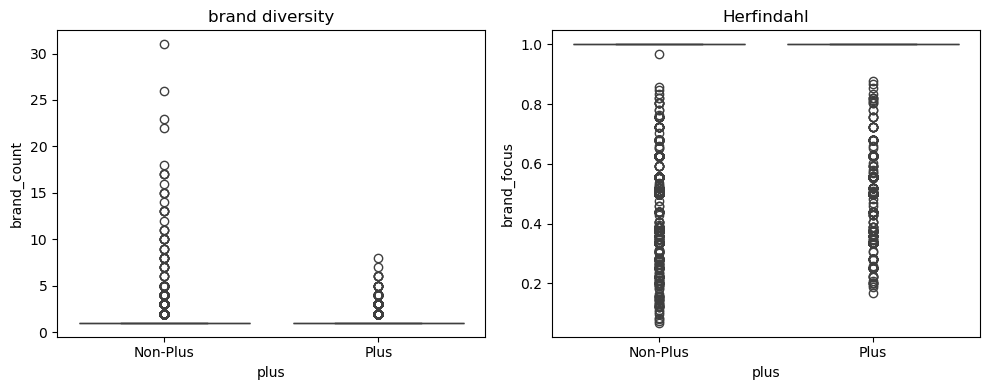

In [69]:

#针对品牌的聚合度做可视化
agg_df['plus'] = agg_df['plus'].map({1: 'Plus', 0: 'Non-Plus'})
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.boxplot(x='plus', y='brand_count', data=agg_df)
plt.title('brand diversity')

plt.subplot(1, 2, 2)
sns.boxplot(x='plus', y='brand_focus', data=agg_df)
plt.title('Herfindahl')

plt.tight_layout()
plt.show()


In [70]:
# sample
agg_df.head(20)

,user_ID,total_spent,is_high_value,plus,brand_focus,brand_count
0,000089d6a6,215.000000,1,Non-Plus,1.0,1.0
1,0000babd1f,39.000000,0,Non-Plus,1.0,1.0
2,0000bc018b,79.000000,0,Non-Plus,1.0,1.0
3,0000d0e5ab,228.000000,1,Non-Plus,1.0,1.0
4,0000dce472,111.500000,1,Plus,1.0,1.0
5,0000f81d1b,150.000000,1,Non-Plus,1.0,1.0
6,00012bb423,52.900000,0,Plus,1.0,1.0
7,00015ff032,3.000000,0,Plus,NaN,NaN
8,0001aa7059,30.080000,0,Non-Plus,1.0,1.0
9,0001bbdc89,45.900000,0,Non-Plus,1.0,1.0


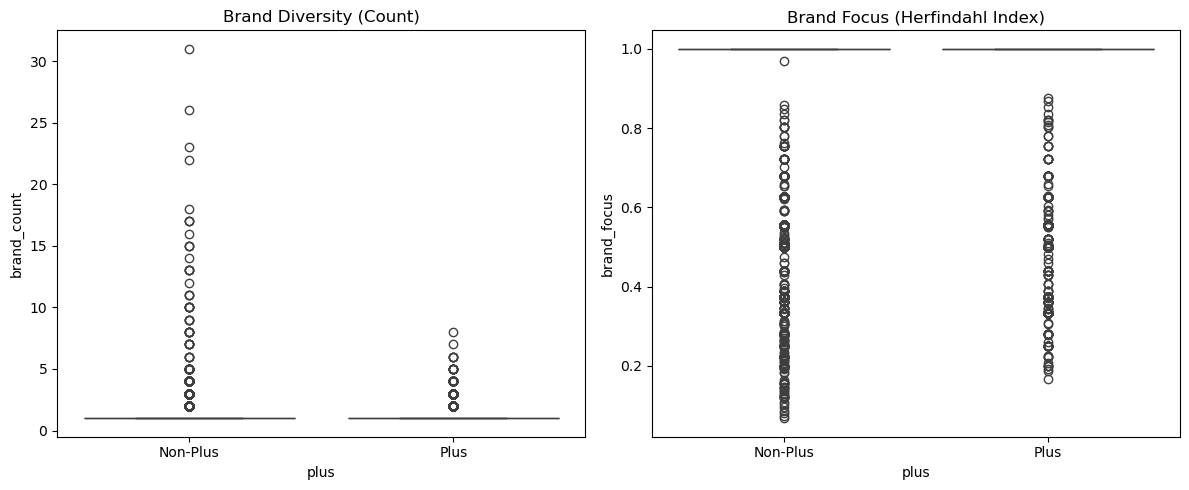

Brand Count t-test:
  t = 17.9241, p = 9.7665e-72
Brand Focus t-test:
  t = -19.4076, p = 9.5000e-84


In [71]:

filtered_df = agg_df[['plus', 'brand_count', 'brand_focus']].dropna()

# t 检验
brand_count_plus = filtered_df[filtered_df['plus'] == 'Plus']['brand_count']
brand_count_nonplus = filtered_df[filtered_df['plus'] == 'Non-Plus']['brand_count']
focus_plus = filtered_df[filtered_df['plus'] == 'Plus']['brand_focus']
focus_nonplus = filtered_df[filtered_df['plus'] == 'Non-Plus']['brand_focus']

t_brand_count = ttest_ind(brand_count_plus, brand_count_nonplus, equal_var=False)
t_focus = ttest_ind(focus_plus, focus_nonplus, equal_var=False)

# 可视化
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='plus', y='brand_count', data=filtered_df)
plt.title('Brand Diversity (Count)')

plt.subplot(1, 2, 2)
sns.boxplot(x='plus', y='brand_focus', data=filtered_df)
plt.title('Brand Focus (Herfindahl Index)')

plt.tight_layout()
plt.show()

# result
print("Brand Count t-test:")
print(f"  t = {t_brand_count.statistic:.4f}, p = {t_brand_count.pvalue:.4e}")
print("Brand Focus t-test:")
print(f"  t = {t_focus.statistic:.4f}, p = {t_focus.pvalue:.4e}")




###  品牌偏好行为分析：Plus 用户 vs 非 Plus 用户

#### 主要对比维度：

| 指标名称                    | 说明                                                   | 统计结果         |
|-----------------------------|--------------------------------------------------------|------------------|
| **品牌数量（brand_count）** | 用户购买过的不同品牌数量，反映品牌多样性             | Plus 用户显著更低 |
| **品牌聚合度（brand_focus）** | Herfindahl 指数，越高说明用户越集中于某些品牌         | Plus 用户显著更高 |

---

#### T 检验结果：

- **品牌多样性差异显著**：
  - `t = 17.92`, `p ≈ 9.77e-72` -> 非 Plus 用户品牌更分散
- **品牌聚合度差异显著**：
  - `t = -19.41`, `p ≈ 9.50e-84` -> Plus 用户更聚焦某些品牌

---

####  结论：
-  Plus 用户更具品牌忠诚：更专注于熟悉品牌。
-  非 Plus 高价值用户偏好多，可能处于品牌购买的探索或尝试阶段。
-  发现品牌行为差异是 Plus 与非 Plus 用户的重要区分因素
####  转化策略：
  - 面向高价值非 Plus 用户，推荐其常购品牌的 Plus 限定福利或专属优惠；
  - 可通过强化品牌认知，推动非Plus用户品牌聚焦度的提升；
  - 品牌方可考虑与平台联合发起高聚合度品牌与Plus权益的联动活动，有助于保留原Plus用户和非Plus用户转化。

----



- 对比当前Plus用户与潜在Plus用户在品牌聚合度上的关联性

In [72]:
current_plus = agg_df[agg_df['plus'] == 'Plus']
potential_plus = agg_df[(agg_df['plus'] == 'Non-Plus') & (agg_df['is_high_value'] == 1)]

#  t-test
ttest_ind(current_plus['brand_focus'].dropna(), potential_plus['brand_focus'].dropna())

TtestResult(statistic=37.66451162313972, pvalue=4.03189410275603e-309, df=163792.0)

###  深入分析：潜在 Plus 用户是否行为类似当前 Plus 用户？


通过T-test对比了当前 Plus 用户与潜在 Plus 用户的品牌聚合度（brand_focus），采用独立样本 t 检验进行显著性分析：

####  T检验检验结果：
- **t 值**：37.6645
- **p 值**：4.03e-309（远小于 0.05）

####  结论：
潜在 Plus 用户在品牌聚合度上 **显著低于** 当前 Plus 用户，说明他们在品牌选择上更分散、忠诚度更低。这表明他们在行为上与当前 Plus 用户仍存在显著差异，转化尚需引导策略。

In [73]:
# 对每个用户统计订单数
order_count_df = orders_users_sku.groupby('user_ID')['order_ID'].nunique().reset_index()
order_count_df.rename(columns={'order_ID': 'order_count'}, inplace=True)

# 合并数据
agg_df = agg_df.merge(order_count_df, on='user_ID', how='left')

agg_df.head(10)

,user_ID,total_spent,is_high_value,plus,brand_focus,brand_count,order_count
0,000089d6a6,215.00,1,Non-Plus,1.0,1.0,1
1,0000babd1f,39.00,0,Non-Plus,1.0,1.0,1
2,0000bc018b,79.00,0,Non-Plus,1.0,1.0,1
3,0000d0e5ab,228.00,1,Non-Plus,1.0,1.0,1
4,0000dce472,111.50,1,Plus,1.0,1.0,1
5,0000f81d1b,150.00,1,Non-Plus,1.0,1.0,1
6,00012bb423,52.90,0,Plus,1.0,1.0,1
7,00015ff032,3.00,0,Plus,NaN,NaN,1
8,0001aa7059,30.08,0,Non-Plus,1.0,1.0,1
9,0001bbdc89,45.90,0,Non-Plus,1.0,1.0,1


###  潜在 Plus 用户转化策略：

#### 关键行为指标差异：
- 潜在 Plus 用户订单金额和频次与当前 Plus 用户接近；
- 品牌聚合度与忠诚度显著低于 Plus 用户。

#### 转化方向：
- 通过绑定 Plus 专属品牌、Plus用户积分回馈等策略，提升品牌聚合度
- 针对其品牌聚合度较低的特点，推送多种品类优惠；
- 采用所有品牌Plus优惠措施（Plus专属所有商品可用优惠券）；
- 定向推送Plus优惠提示；

---


- 建模预测高价值潜在PLUS用户转化概率

In [74]:

# 特征列 
feature_cols = ['total_spent', 'order_count', 'brand_count', 'brand_focus']
label_col = 'plus'
X = agg_df[feature_cols]
y = agg_df[label_col]
user_ids = agg_df['user_ID'] 
# 缺失值填补
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
# 加入 user_ids
X_train, X_test, y_train, y_test, user_train, user_test = train_test_split(
    X_imputed, y, user_ids, test_size=0.3, stratify=y, random_state=42
)

# 建模预测
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# result
# 混淆矩阵和评估报告
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Confusion Matrix:
 [[78532 33868]
 [11901 12169]]

Classification Report:
               precision    recall  f1-score   support

    Non-Plus       0.87      0.70      0.77    112400
        Plus       0.26      0.51      0.35     24070

    accuracy                           0.66    136470
   macro avg       0.57      0.60      0.56    136470
weighted avg       0.76      0.66      0.70    136470



- 按照转化概率排序建立潜在会员用户表单

In [75]:
# 结果输出
result_df = pd.DataFrame({
    'user_ID': user_test.reset_index(drop=True),
    'true_label': y_test.reset_index(drop=True),
    'predicted_label': y_pred,
    'prob_plus': y_proba
})
non_plus_df = result_df[result_df['true_label'] != 'Plus']
# 按照转化概率排序
top_candidates = non_plus_df.sort_values('prob_plus', ascending=False)
top_candidates.head(2000) 


,user_ID,true_label,predicted_label,prob_plus
39644,3554bb0a78,Non-Plus,Plus,1.000000
93575,9372a3e20d,Non-Plus,Non-Plus,1.000000
93377,b12400a20c,Non-Plus,Plus,1.000000
14754,3f259c393e,Non-Plus,Plus,1.000000
11290,26ca6566b9,Non-Plus,Plus,1.000000
...,...,...,...,...
54628,af3322c613,Non-Plus,Non-Plus,0.862238
48055,70f55591b4,Non-Plus,Plus,0.861779
113121,53f67156bf,Non-Plus,Non-Plus,0.861704
55617,bd308491d6,Non-Plus,Non-Plus,0.861704



###  分析目标  
- 希望从当前的非 Plus 用户中识别出一批最有可能转化为 Plus 的用户，辅助精准营销和策略制定。



###  建模: 

1. 特征选择：
   - 使用了用户的 4 个关键行为特征：  
     `total_spent`, `order_count`, `brand_count`, `brand_focus`

2. 模型构建：
   - 采用 Random Forest 分类模型，处理类别不平衡 (`class_weight='balanced'`)
   - 训练集与测试集按照 70%:30% 划分

3. 性能总结：
   - 模型整体准确率约为 66%；
   - 对 Plus 用户的识别召回率为 52%，说明能识别出一部分目标人群；
   - 精确率偏低（约26%）。

---

### 小结：
- 在分析过程中注意到Plus用户的品牌忠诚度较高，可能因为Plus用户对于平台的使用时间较长，潜在Plus用户可能还处于品牌探索与平台尝试阶段，认为可对这两类用户群体的使用时间进行深入分析以制定更完善的营销转化策略。

---


### 探究使用时长的影响

- 处理users中的‘第一次下单’数据

In [76]:
current_month = pd.to_datetime("2025-06")

# 转换 first_order_month 为 datetime 类型
users['first_order_month'] = pd.to_datetime(users['first_order_month'])

# 计算使用时长（以月为单位）
users['usage_months'] = (current_month.year - users['first_order_month'].dt.year) * 12 + \
                        (current_month.month - users['first_order_month'].dt.month)
users.head(10)

,user_ID,user_level,first_order_month,plus,gender,age,marital_status,education,city_level,purchase_power,usage_months
0,000089d6a6,1,2017-08-01,0,F,26-35,S,3,4,3,94
1,0000babd1f,1,2018-03-01,0,U,U,U,-1,-1,-1,87
2,0000bc018b,3,2016-06-01,0,F,>=56,M,3,2,3,108
3,0000d0e5ab,3,2014-06-01,0,M,26-35,M,3,2,2,132
4,0000dce472,3,2012-08-01,1,U,U,U,-1,-1,-1,154
5,0000f81d1b,1,2018-02-01,0,F,26-35,M,2,3,2,88
6,00012bb423,4,2008-11-01,1,F,26-35,M,4,1,2,199
7,00015ff032,3,2015-06-01,1,M,26-35,M,3,4,1,120
8,0001aa7059,4,2014-06-01,0,F,36-45,M,3,4,2,132
9,0001bbdc89,2,2017-12-01,0,F,16-25,S,3,2,2,90


In [77]:
# 保留 user_ID 和 usage_months 两列
usage_df = users[['user_ID', 'usage_months']]

# 合并到 current_plus（当前 Plus 用户）
current_plus = pd.merge(current_plus, usage_df, on='user_ID', how='left')

# 合并到 potential_plus_users（潜在 Plus 用户）
potential_plus = pd.merge(potential_plus, usage_df, on='user_ID', how='left')
potential_plus.head(100)


,user_ID,total_spent,is_high_value,plus,brand_focus,brand_count,usage_months
0,000089d6a6,215.000000,1,Non-Plus,1.0,1.0,94
1,0000d0e5ab,228.000000,1,Non-Plus,1.0,1.0,132
2,0000f81d1b,150.000000,1,Non-Plus,1.0,1.0,88
3,0001f75444,344.833333,1,Non-Plus,1.0,1.0,147
4,00020f8411,150.000000,1,Non-Plus,1.0,1.0,103
...,...,...,...,...,...,...,...
95,004d303349,169.000000,1,Non-Plus,1.0,1.0,91
96,004d77cfab,148.000000,1,Non-Plus,1.0,1.0,87
97,004e033564,292.000000,1,Non-Plus,0.5,2.0,101
98,004e9e37d6,184.000000,1,Non-Plus,0.5,2.0,90


- 潜在Plus用户和Plus用户使用时长基础分析

In [78]:
print("当前 Plus 用户使用时长统计：")
print(current_plus['usage_months'].describe()[['mean', '50%', 'std']])

print("\n潜在 Plus 用户使用时长统计：")
print(potential_plus['usage_months'].describe()[['mean', '50%', 'std']])

当前 Plus 用户使用时长统计：
mean    137.955256
50%     137.000000
std      26.918365
Name: usage_months, dtype: float64

潜在 Plus 用户使用时长统计：
mean    116.024310
50%     111.000000
std      24.325134
Name: usage_months, dtype: float64


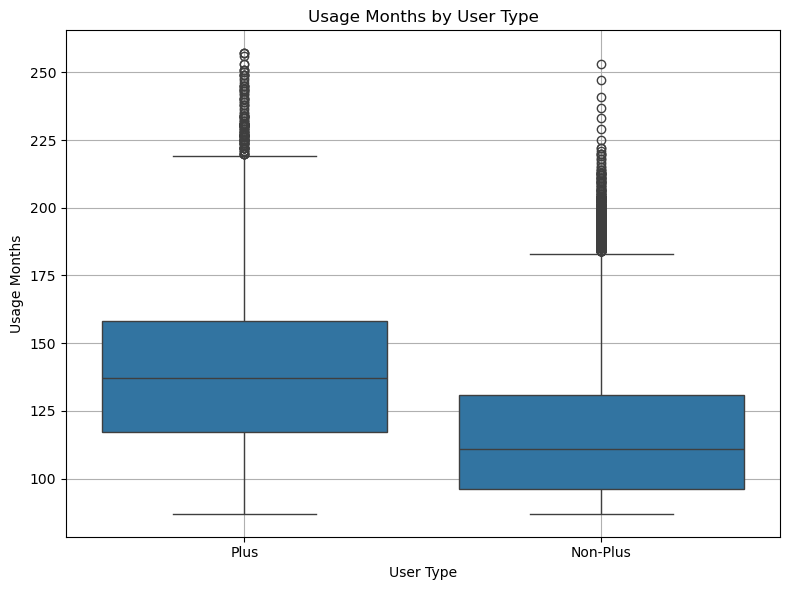

 t-test result：
T statistic: 176.1554
P value    : 0.0000e+00


In [79]:
combined_df = pd.concat([
    current_plus[['user_ID', 'usage_months']].assign(plus='Plus'),
    potential_plus[['user_ID', 'usage_months']].assign(plus='Non-Plus')
])

#  可视化
plt.figure(figsize=(8, 6))
sns.boxplot(x='plus', y='usage_months', data=combined_df)
plt.title('Usage Months by User Type')
plt.ylabel('Usage Months')
plt.xlabel('User Type')
plt.grid(True)
plt.tight_layout()
plt.show()

#  t 检验：使用时长是否在 Plus 与非 Plus 用户之间存在显著差异
plus_months = current_plus['usage_months'].dropna()
non_plus_months = potential_plus['usage_months'].dropna()

t_stat, p_val = ttest_ind(plus_months, non_plus_months)

print(" t-test result：")
print(f"T statistic: {t_stat:.4f}")
print(f"P value    : {p_val:.4e}")

###  平台使用时长与 Plus 用户的关系分析报告

#### 1. 分析目的
探究用户的使用时长（`usage_months`）是否与其是否为 Plus 用户存在显著差异，验证使用时长是否为潜在转化的重要指标。

---

#### 2. 可视化分析（箱线图）

- **观察结果**：
  - Plus 用户的使用时长中位数显著高于 Non-Plus 用户
  - Plus 用户的整体分布也更高
  - 极端值虽存在，但中位数差距明显。

---

#### 3. 统计检验（t-test）

| 指标        | 值         |
|-------------|------------|
| T statistic | 176.1554   |
| P value     | 0.0000e+00 |

- **检验结论**：
  - 由于 p-value 极小（远小于 0.05），说明 Plus 与 Non-Plus 用户的使用时长在统计上存在显著差异。
  - 可初步推断：**使用时长越长，用户转化为 Plus 的概率越高。**

---


- 将使用时长作为特征值加入模型

In [80]:
# 从 users 表中提取 user_ID 和 usage_months
usage_df = users[['user_ID', 'usage_months']]

# 合并到 agg_df 中
agg_df = agg_df.merge(usage_df, on='user_ID', how='left')
agg_df.head(10)

,user_ID,total_spent,is_high_value,plus,brand_focus,brand_count,order_count,usage_months
0,000089d6a6,215.00,1,Non-Plus,1.0,1.0,1,94
1,0000babd1f,39.00,0,Non-Plus,1.0,1.0,1,87
2,0000bc018b,79.00,0,Non-Plus,1.0,1.0,1,108
3,0000d0e5ab,228.00,1,Non-Plus,1.0,1.0,1,132
4,0000dce472,111.50,1,Plus,1.0,1.0,1,154
5,0000f81d1b,150.00,1,Non-Plus,1.0,1.0,1,88
6,00012bb423,52.90,0,Plus,1.0,1.0,1,199
7,00015ff032,3.00,0,Plus,NaN,NaN,1,120
8,0001aa7059,30.08,0,Non-Plus,1.0,1.0,1,132
9,0001bbdc89,45.90,0,Non-Plus,1.0,1.0,1,90


In [81]:
#  特征列
feature_cols = ['total_spent', 'order_count', 'brand_count', 'brand_focus', 'usage_months']
label_col = 'plus'
X = agg_df[feature_cols]
y = agg_df[label_col]
user_ids = agg_df['user_ID']

#  缺失值填补
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

X_train, X_test, y_train, y_test, user_train, user_test = train_test_split(
    X_imputed, y, user_ids, test_size=0.3, stratify=y, random_state=42
)

#  建模
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

#  result
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


# 输出潜在高转化概率用户表单
result_df = pd.DataFrame({
    'user_ID': user_test.reset_index(drop=True),
    'true_label': y_test.reset_index(drop=True),
    'predicted_label': y_pred,
    'prob_plus': y_proba
})
non_plus_df = result_df[result_df['true_label'] != 'Plus']
# 排序展示潜在可转化用户
top_candidates = non_plus_df.sort_values('prob_plus', ascending=False)
top_candidates.head(2000)


Confusion Matrix:
 [[89025 23375]
 [12032 12038]]

Classification Report:
               precision    recall  f1-score   support

    Non-Plus       0.88      0.79      0.83    112400
        Plus       0.34      0.50      0.40     24070

    accuracy                           0.74    136470
   macro avg       0.61      0.65      0.62    136470
weighted avg       0.79      0.74      0.76    136470



,user_ID,true_label,predicted_label,prob_plus
39644,3554bb0a78,Non-Plus,Plus,1.000000
93575,9372a3e20d,Non-Plus,Plus,1.000000
93377,b12400a20c,Non-Plus,Plus,1.000000
14754,3f259c393e,Non-Plus,Plus,1.000000
11290,26ca6566b9,Non-Plus,Plus,1.000000
...,...,...,...,...
54628,af3322c613,Non-Plus,Plus,0.862238
48055,70f55591b4,Non-Plus,Plus,0.861779
113121,53f67156bf,Non-Plus,Plus,0.861704
55617,bd308491d6,Non-Plus,Plus,0.861704


##  最终结论分析：识别潜在 Plus 用户并进行营销转化

### 模型对比分析：使用时长特征的影响

本次实验对比了未加入与加入“使用时长（usage_months）”作为特征的模型表现，旨在评估该变量对 Plus 用户识别能力的提升作用。

---

###  主要对比指标（以 Plus 用户为目标类）：

| 指标         | 未加入使用时长 | 加入使用时长 | 差异说明               |
|--------------|----------------|----------------|------------------------|
| Precision    | 0.26           | 0.34       | 显著提高，误识别率下降 |
| Recall       | 0.51           | 0.50            | 稍微下降                |
| F1-score     | 0.35           | 0.40        | 提升，综合表现更优     |
| Accuracy     | 0.66           | 0.74        | 整体分类能力提升       |
| Macro Avg F1 | 0.56           | 0.62        | 各类平均性能提升       |
| Weighted Avg F1 | 0.70        | 0.76        | 面向真实分布的提升     |

---

###  解读：

- Precision 提高：说明模型在预测为 Plus 的样本中，正确比例增大，误报少了。
- Recall 稍降但稳定：表示模型仍能识别出大部分 Plus 用户。
- F1-score 明显提升：反映出 precision 和 recall 的综合性能更好。
- Accuracy 提升：模型整体准确率提升显著，受益于更有效的特征输入。
- 总体表现更平衡：macro/weighted F1 的同步上升说明改进对两类样本都更友好。

---

###  筛选逻辑  

- 在所有非 Plus 用户中，按模型预测的 `prob_plus` 转化概率从高到低排序；
- 提取出前 2,000 名预测概率最高的用户，构建了潜在高价值转化用户名单。

---

###  模型结论：

加入“使用时长”作为特征后，模型对 Plus 用户识别能力更强、误判更少，整体分类效果显著提升。

---

###  落地策略：  

#### 1. 精准推送优惠信息
   - 对这 2,000 名高潜用户，可分层发放 Plus 优惠券、提前试用、满减等激励措施；
   - 结合用户行为特征设计差异化推荐文案。

#### 2. 开展A/B Test 
   - 将该人群作为实验目标组，对比实际转化率与普通用户组的差异；
   - 跟踪点击率、加购率、开通率等，进一步验证模型预测效果。

---

#### 总结：
- 本次分析通过机器学习模型识别出了一批高概率潜在 Plus 用户，并结合行为数据与预测概率构建了精准营销候选名单。该名单可为市场推广、会员转化提供数据支持，由于本人还未系统学习机器学习，导致模型的精准度和recall还是偏低，还需要进一步优化。
